In [18]:
from dataclasses import dataclass
import json
import dpath
from typing import List, Dict
import pandas as pd
import math

def open_results_file(filepath: str):
    with open(filepath) as f:
        data = json.loads(f.read())
    return data

def get_words_from_results(data: Dict):
    words = []
    for _, word in dpath.search(
        data,
        'responses/*/fullTextAnnotation/pages/*/blocks/*/paragraphs/*/words',yielded=True):
        words.append(word)
    return words

def get_tokens_from_words(results: List):
    tokens = []
    for words in results:
        for word in words:
            verts = word['boundingBox']['normalizedVertices']
            left, top = verts[0]['x'], verts[0]['y']
            right, bottom = verts[2]['x'], verts[2]['y']
            rect = [left,top,right,bottom]
            tokens.append(Token(rect, word['symbols'], word['confidence']))
    return Tokens(tokens)


class Token:
    def __init__(self, rectangle:List, symbols:List, confidence:float) -> None:
        self.rectangle = rectangle
        self.symbols = symbols
        self.confidence = confidence
        self.left = self.rectangle[0]
        self.top = 1-self.rectangle[1]
        self.right = self.rectangle[2]
        self.bottom = 1-self.rectangle[3]
    
    @property
    def text(self) -> str:
        return ''.join(char.get('text',' ') for char in self.symbols)

    @property
    def height(self) -> float:
        return self.top-self.bottom
    
    @property
    def length(self) -> float:
        return self.right-self.left

    def __repr__(self):
        return f'Y:{self.top:.3f} X:{self.left:.3f} ---- "{self.text}" ({self.confidence:.02f})'

class Tokens:
    
    def __init__(self, tokens: list) -> None:
        self.tokens=tokens

    truncate = 3
    epsilon = 0.007
    

    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self.tokens):
            raise StopIteration
        value = self.tokens[self.index]
        self.index += 1
        return value

    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, index):
        return self.tokens[index]

    def __repr__(self):
        return '\n'.join(str(token) for token in self.tokens)

    @property
    def sorted_tokens(self) -> list:
        return sorted(
            self.tokens,
            key=lambda token: (-token.top, token.left),
        )

    def truncate_values(self, values: list, truncate: int):
        return [round(value, truncate) for value in values]

    def get_all_values(self, attribute: str):
        assert attribute in ['top', 'left', 'right', 'bottom'], 'Invalid attribute name'
        return [getattr(token, attribute) for token in self.tokens]
    
    @property
    def lines(self):
        new_line, lines = [], []
        prev_y = math.inf
        for token in self.sorted_tokens:
            is_new_line = bool(abs(token.top - prev_y) > self.epsilon)
            if is_new_line:
                lines.append(new_line)
                new_line=[]
                prev_y = token.top
            new_line.append(token)
            new_line.sort(key=lambda token: token.left)
        lines.append(new_line)
        return lines
    
    @property
    def columns(self):
        ...


   





tokens = get_tokens_from_words(get_words_from_results(open_results_file('pag9_d.json')))

tokens.lines



[[],
 [Y:0.964 X:0.513 ---- "8" (0.96)],
 [Y:0.929 X:0.133 ---- "Receita" (0.99),
  Y:0.929 X:0.267 ---- "do" (0.99),
  Y:0.929 X:0.313 ---- "Imperio" (0.99),
  Y:0.929 X:0.449 ---- "no" (0.99),
  Y:0.929 X:0.496 ---- "exercicio" (0.94),
  Y:0.929 X:0.659 ---- "de" (0.99),
  Y:0.929 X:0.706 ---- "1848-1849" (0.87),
  Y:0.929 X:0.908 ---- "." (0.98)],
 [Y:0.879 X:0.319 ---- "DENOMINAÇÃO" (0.94),
  Y:0.879 X:0.415 ---- "DAS" (0.96),
  Y:0.879 X:0.444 ---- "RENDAS" (0.94),
  Y:0.879 X:0.492 ---- "." (0.90),
  Y:0.878 X:0.703 ---- "ARRECADADA" (0.96),
  Y:0.876 X:0.787 ---- "." (0.98),
  Y:0.875 X:0.850 ---- "POR" (0.91)],
 [Y:0.865 X:0.824 ---- "ARRECADAR" (0.94), Y:0.865 X:0.897 ---- "." (0.98)],
 [Y:0.836 X:0.353 ---- "RENDA" (0.97),
  Y:0.836 X:0.410 ---- "GERAL" (0.98),
  Y:0.836 X:0.461 ---- "." (0.94)],
 [Y:0.812 X:0.371 ---- "ORDINARIA" (0.95), Y:0.812 X:0.440 ---- "." (0.78)],
 [Y:0.792 X:0.370 ---- "Importação" (0.94), Y:0.792 X:0.440 ---- "." (0.89)],
 [Y:0.772 X:0.131 ---- "Dir

In [20]:
for token in tokens:
    print(token.text, token.height, token.length)

8 0.01781472499999992 0.021848699999999943
Receita 0.023752965000000015 0.11596638000000001
do 0.023752965000000015 0.035294119999999984
Imperio 0.023752965000000015 0.12436975
no 0.023752965000000015 0.035294099999999995
exercicio 0.023752965000000015 0.14285718000000003
de 0.023752965000000015 0.033613449999999934
1848-1849 0.023752965000000015 0.19495794
. 0.023752965000000015 0.006722669999999931
DENOMINAÇÃO 0.008313545000000033 0.08739495999999997
DAS 0.008313545000000033 0.021848739999999978
RENDAS 0.008313545000000033 0.04705882
. 0.008313545000000033 0.0033613399999999904
RENDA 0.008313529999999902 0.04705880000000001
GERAL 0.007125880000000029 0.04705882
. 0.007125880000000029 0.0033613500000000407
ORDINARIA 0.005938230000000044 0.06890755999999998
. 0.005938230000000044 0.0033613399999999904
Importação 0.009501179999999998 0.07058823999999997
. 0.009501179999999998 0.005042009999999986
Direitos 0.009501200000000098 0.04873949999999999
de 0.008313540000000064 0.013445380000000

In [12]:
tokens.column_angle

AttributeError: 'Tokens' object has no attribute 'column_angle'

In [20]:
tokens[9].symbols

[{'text': 'D', 'confidence': 0.9426736},
 {'text': 'E', 'confidence': 0.9447651},
 {'text': 'N', 'confidence': 0.9683293},
 {'text': 'O', 'confidence': 0.97745353},
 {'text': 'M', 'confidence': 0.98423773},
 {'text': 'I', 'confidence': 0.97857374},
 {'text': 'N', 'confidence': 0.9828221},
 {'text': 'A', 'confidence': 0.9680033},
 {'text': 'Ç', 'confidence': 0.8934318},
 {'text': 'Ã', 'confidence': 0.79865474},
 {'property': {'detectedBreak': {'type': 'SPACE'}},
  'text': 'O',
  'confidence': 0.9348914}]

In [8]:
results

{'inputConfig': {'gcsSource': {'uri': 'gs://tcc-caio-donalisio/pag9_d.pdf'},
  'mimeType': 'application/pdf'},
 'responses': [{'fullTextAnnotation': {'pages': [{'property': {'detectedLanguages': [{'languageCode': 'pt',
         'confidence': 0.69947153},
        {'languageCode': 'gl', 'confidence': 0.026765456},
        {'languageCode': 'es', 'confidence': 0.021930488},
        {'languageCode': 'en', 'confidence': 0.009010724},
        {'languageCode': 'la', 'confidence': 0.005045437},
        {'languageCode': 'lv', 'confidence': 0.0030384182}]},
      'width': 595,
      'height': 842,
      'blocks': [{'boundingBox': {'normalizedVertices': [{'x': 0.13277312,
           'y': 0.035629455},
          {'x': 0.9142857, 'y': 0.036817104},
          {'x': 0.9142857, 'y': 0.09619953},
          {'x': 0.13277312, 'y': 0.095011875}]},
        'paragraphs': [{'boundingBox': {'normalizedVertices': [{'x': 0.5126051,
             'y': 0.035629455},
            {'x': 0.5344538, 'y': 0.035629455},
 

[-0.03686088  0.00118906  0.          0.00118906  0.          0.00118906
  0.00118906  0.00118906 -0.05469679  0.00118906  0.          0.
 -0.0451843   0.00118906  0.00118906 -0.02497027  0.         -0.02140309
  0.00118905 -0.02259214  0.          0.          0.         -0.01070155
  0.          0.          0.          0.          0.          0.
  0.         -0.01070153  0.          0.          0.          0.
  0.          0.          0.         -0.01189063  0.          0.
  0.          0.00118908  0.          0.          0.00118905  0.
  0.          0.         -0.01307967  0.          0.          0.
  0.          0.00118907  0.          0.          0.00118904  0.
  0.00118908  0.         -0.01426872  0.          0.          0.00118905
  0.          0.00118905  0.          0.          0.          0.
  0.00118905  0.          0.00118909  0.          0.          0.
 -0.01545781  0.          0.          0.00118907  0.          0.
  0.00118906  0.          0.00118906  0.          0.001189

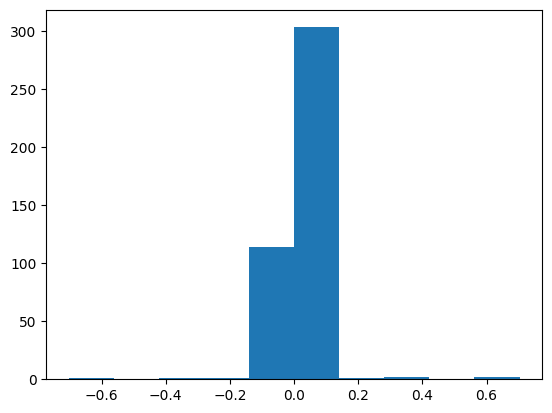

In [115]:
 @property
    def column_angle(self):
        tilt = 0.01
        minim = min(self.get_all_values('left'))
        new_tokens = [token for token in self.tokens if abs(token.left - minim) <= tilt]
        if len(new_tokens) < 2:
            ...
        sorted_tokens = sorted(new_tokens, key=lambda token: token.top, reverse=True)
        first, last = sorted_tokens[0], sorted_tokens[-1]
        try:
            delta_y = (first.top - last.top)/(first.left-last.left)
        except ZeroDivisionError:
            delta_y = math.inf
        angle = -(math.atan(delta_y) - (math.pi/2))
        return math.degrees(angle)
    
    def rotate_points(self):
        col_ang = self.column_angle
        for token in self.tokens:
            rotated_left = token.left * math.cos(col_ang) - token.top * math.sin(col_ang)
            rotated_top = token.left * math.sin(col_ang) + token.top * math.cos(col_ang)
            token.left = rotated_left
            token.top = rotated_top
        self.rotated = True